In [1]:
print('hi')

hi


In [1]:
#import libraries
import gym

import time
import wandb
import numpy as np

import torch 
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm 
from dataclasses import dataclass
from typing import Any
from models import Model as Stock_NN
from models import ConvModel2 as Stock_NN

import matplotlib.pyplot as plt
is_ipython = 'inline' in plt.get_backend()
if is_ipython: from IPython import display
if is_ipython: display.clear_output(wait=True)


In [2]:
import random
class Exp_Replay:
    """Experience replay, old samples are removed beyond specified limit
    stores collection of experience tuples (sars), this combats experience correlation"""
    def __init__(self, buffer_n = int(1e5)):   
        
        self.buffer_n = buffer_n
        self.buffer = [None]*buffer_n
        self.idx = 0
        
    def insert(self, sars):
        i = self.idx % self.buffer_n
        self.buffer[i] = sars
        self.idx +=1 # updat index
        
    def sample(self, n_sample):
        if self.idx < self.buffer_n:
            return random.sample(self.buffer[:self.idx], n_sample)
        return random.sample(self.buffer, n_sample)
    
# for data storage
@dataclass
class Sars: # store experience tuples
    state: Any
    action: int
    reward: float
    next_state : Any
    done : bool


In [3]:
class DQN_Agent:
    
    def __init__(self, env,
                 learning_rate = 1e-4, 
                 discount_rate = 0.99,
                 eps_max = 0.9, 
                 eps_min = 0.01,
                 eps_decay = 1e-6, 
                 boltzman_exploration = False,
                 min_rb_size = int(2e4), 
                 sample_size = 100,
                 model_train_freq = 100,
                 tgt_update_freq = 5000,
                 max_epoch = np.inf, 
                 load_model = None,
                 device = 'cuda:0',
                 name = 'Breakout'):
        
        self.lr = learning_rate
        self.gamma = discount_rate
        self.eps_max = eps_max
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        
        self.boltzman = boltzman_exploration 
        self.min_rb = min_rb_size
        self.sample_size = sample_size 
        self.model_train_freq = model_train_freq 
        self.tgt_update_freq = tgt_update_freq
        self.max_epoch = max_epoch 
        self.load_model = load_model
        self.device = device
        self.name = name
        
        self.log = {'loss': [],
                    'avg_reward': [],
                    'eps': [],
                    'step_num': []}
        
        # init env
        self.env = env #gym.make('stocks-v0', frame_bound=(15, 200), window_size=15)
        
        return
    
    def choose_action(self, eps):
        
        if self.boltzman: # use boltzman exploration
                logits = self.m(torch.Tensor(self.last_observation)#[:,0])
                                .unsqueeze(0).to(self.device))[0]
                action = torch.distributions.Categorical(logits = logits).sample().item()
        else:
            if np.random.random() < eps: # explore action space
                action = self.env.action_space.sample()
            else: # greedy action
                action = self.m(torch.Tensor(self.last_observation)#[:,0])
                           .unsqueeze(0).to(self.device)).max(-1)[-1].item()
        return action
    
    def run_episode(self, episode):
        '''runs one episode in the taining process.'''
        
        # compute decaying exploration rate as a function of episode
        eps = (self.eps_max - self.eps_min) * np.exp(-self.eps_decay*self.step_count) + self.eps_min
        
        
        self.last_observation = self.env.reset()
        #self.last_observation = self.last_observation[:,0]
        done = False
        
        def f(x):
            return 2/ (1+np.exp(-0.2*x) ) - 1
        
        rolling_reward = 0
        norm_reward = 0
        
        while not done: # until episode ends
            self.tq.update()

            # choose action
            action = self.choose_action(eps)

            # observe state reward by taking action
            obs, reward, done, info = self.env.step(action)
            rolling_reward += reward # sum reward for episode
            #reward = f(reward)
            norm_reward += reward
            
            # insert experienc tuple at top of buffer
            self.rb.insert(Sars(self.last_observation#[:,0]
                                , action, reward, obs#[:,0]
                                , done))

            self.last_observation = obs#[:,0] # update observation
            
            #  counters
            self.steps_since_train += 1
            self.step_num += 1
            self.step_count += 1

            # train prediction network
            if self.rb.idx > self.min_rb and self.steps_since_train > self.model_train_freq:

                # train model neural network
                loss = self.train_NN(self.m, 
                                     self.rb.sample(self.sample_size), 
                                     self.tgt,
                                     self.env.action_space.n,
                                     self.device)
                self.steps_since_train = 0 # reset train counter
                
                
                wandb.log({'loss': loss.detach().cpu().item(), 
                           'epsilon': eps, 
                           'avg_reward': self.episode_rewards[-1], 
                           'norm_reward': self.norm_reward},
                          step = self.step_num)
                self.save_reward = np.mean(self.episode_rewards[-1])

                self.epochs_since_tgt_update +=1

                # update target nn
                if self.epochs_since_tgt_update > self.tgt_update_freq:
                    self.tgt.load_state_dict(self.m.state_dict())
                    self.epochs_since_tgt_update = 0

                self.epoch += 1
                    
            self.log['avg_reward'].append(rolling_reward)
            self.log['eps'].append(eps)
            self.log['step_num'].append(self.step_num)
        self.norm_reward = norm_reward
        return rolling_reward# return episode rewards
    
    def train_NN(self, 
                 model,
                 transition, 
                 tgt, 
                 num_actions, 
                 device):
        '''trains model passed'''
        
        curr_states = torch.stack([torch.Tensor(s.state) for s in transition]).to(device)
        rewards = torch.stack([torch.Tensor([s.reward]) for s in transition]).to(device)
        next_states = torch.stack([torch.Tensor(s.next_state) for s in transition]).to(device)
        actions = [s.action for s in transition]
        if_done = torch.stack([torch.Tensor([0]) if s.done else torch.Tensor([1]) for s in transition]).to(device)
        
        

        with torch.no_grad(): # get best next actions with target network
            next_qvals = tgt(next_states).max(-1)[0] #(N, num_actions)

        model.opt.zero_grad()
        qvals = model(curr_states) # shape: (N, num_actins), get qvals of current state
        H_actions = torch.nn.functional.one_hot(torch.LongTensor(actions), num_actions).to(device)
        
        # MSE loss function
        #loss = ((rewards + if_done[:,0]*next_qvals - torch.sum(qvals * H_actions, -1))**2).mean()

        f_loss = torch.nn.SmoothL1Loss()
        target = torch.sum(qvals * H_actions, -1)
        inputs = rewards.squeeze() + if_done[:,0]*self.gamma*next_qvals # Bellman optimality
        loss = f_loss(target, inputs )
        loss.backward()
        model.opt.step()

        return loss
    
    def train(self):
        '''begin training by running episodes until max or interrupted'''
        
        # init w and b for data viz in dashboard
        wandb.init(project = "Dissertation_Final", name = self.name)    
        
        # instantiate prediction network
        self.m = Stock_NN(self.env.observation_space.shape,
                           self.env.action_space.n).to(self.device)
        if self.load_model is not None:
            self.m.load_state_dict(torch.load(self.load_model))
        
        # instantiate target network
        self.tgt = Stock_NN(self.env.observation_space.shape, 
                        self.env.action_space.n).to(self.device)
        self.tgt.load_state_dict(self.m.state_dict()) 
        
        # instantiate buffer
        self.rb = Exp_Replay()
        
        # init counterstw
        self.epoch = 0
        self.steps_since_train = 0
        self.epochs_since_tgt_update = 0
        self.step_num = -self.min_rb
        self.step_count = 0
        self.episode_rewards = [np.nan]
        episode = 0
        
        self.tq = tqdm()
        try:
            while episode < self.max_epoch:

                self.episode_rewards.append(self.run_episode(episode))
                episode += 1
                #print(episode)
                clear_output(wait=True)
            r = str(np.random.random())[2:8]
            torch.save(self.tgt.state_dict(), 
                   f"models/Diffusion_{self.step_num}_{r}.pth")
            print('Training Completed.')
        except KeyboardInterrupt: # save model on interrupt
            r = str(np.random.random())[2:8]
            torch.save(self.tgt.state_dict(), 
                   f"models/Diffusion_{self.step_num}_{r}.pth")
            print('Training Interrupted')
        
    
    def test_episode(self, env = None, plot = False, load_model = None):
        
        if env is not None:
            self.env = env
        
        
        if load_model is not None:
            # instantiate prediction network
            self.m = Stock_NN(self.env.observation_space.shape,
                           self.env.action_space.n).to(self.device)
            self.m.load_state_dict(torch.load(load_model))
            
        frames = []
        obs = self.env.reset()
        
        idx = 0
        reward = 0
        done = False
        
        while not done:
            
            action = self.m(torch.Tensor(obs[:,0]).unsqueeze(0).to(self.device)).max(-1)[-1].item()
            obs, r, done, _ = self.env.step(action)
            reward += r
            
            if plot:
                a = self.env.render()
                #plt.figure()
                #plt.imshow(a)
                #plt.show()
                #time.sleep(0.001)
                clear_output(wait=True)
                
        return reward
    

In [4]:
from environment import heat_diffusion
from wrapper import PINN_env

sensor_coords = [[0.1, -0.9],[0.9,0.9],[0.5,0.45]]
env = heat_diffusion(dt = 1e-1, sensor_coords = sensor_coords,
                    noisy_IC = True,
                    norm_reward = False,
                    scale_reward = True)

env_pinn = PINN_env(env, norm_obs = True)

0it [00:00, ?it/s]
0it [00:00, ?it/s]

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
#for i in range(10):
Agent = DQN_Agent(env_pinn,
             learning_rate = 1e-4, 
             discount_rate = 0.99,
             eps_max = 0.5, 
             eps_min = 0.05,
             eps_decay = 6e-5, 
             boltzman_exploration = False,
             min_rb_size = 10000, 
             sample_size = 500,
             model_train_freq = 5,
             tgt_update_freq = 1000,
             max_epoch = 400, 
             load_model = None,#'models/Diffusion_9950_.pth',
             device = 'cuda:0',
             name = 'new_Heat_diffusion_OG_decay_10k_0.5_test_env_'+str(933))

In [ ]:
Agent.train()



1260it [07:52,  2.05it/s]

1261it [07:52,  2.33it/s]

1262it [07:53,  2.57it/s]

1263it [07:53,  2.71it/s]

1264it [07:53,  2.66it/s]

1265it [07:54,  2.83it/s]

1266it [07:54,  2.98it/s]

1267it [07:54,  3.10it/s]

1268it [07:55,  3.19it/s]

1269it [07:55,  2.99it/s]

1270it [07:55,  2.59it/s]

1271it [07:56,  2.52it/s]

1272it [07:56,  2.50it/s]

1273it [07:57,  2.54it/s]

1274it [07:57,  2.72it/s]

1275it [07:57,  2.92it/s]

1276it [07:58,  3.02it/s]

1277it [07:58,  3.15it/s]

1278it [07:58,  3.26it/s]

1279it [07:58,  3.35it/s]

1280it [07:59,  3.47it/s]

1281it [07:59,  3.51it/s]

1282it [07:59,  3.49it/s]

1283it [08:00,  3.46it/s]

1284it [08:00,  3.45it/s]

1285it [08:00,  3.44it/s]

1286it [08:00,  3.43it/s]

1287it [08:01,  3.45it/s]

1288it [08:01,  3.46it/s]

1289it [08:01,  3.45it/s]

1290it [08:02,  3.46it/s]

1291it [08:02,  3.43it/s]

1292it [08:02,  3.10it/s]

1293it [08:03,  2.96it/s]

1294it [08:03,  2.99it/s]

1295it [08:03,  3.06it/s]

1296it [08:04,  3.07it/s]


In [ ]:
env_pinn.save_PINN(id = 27045)

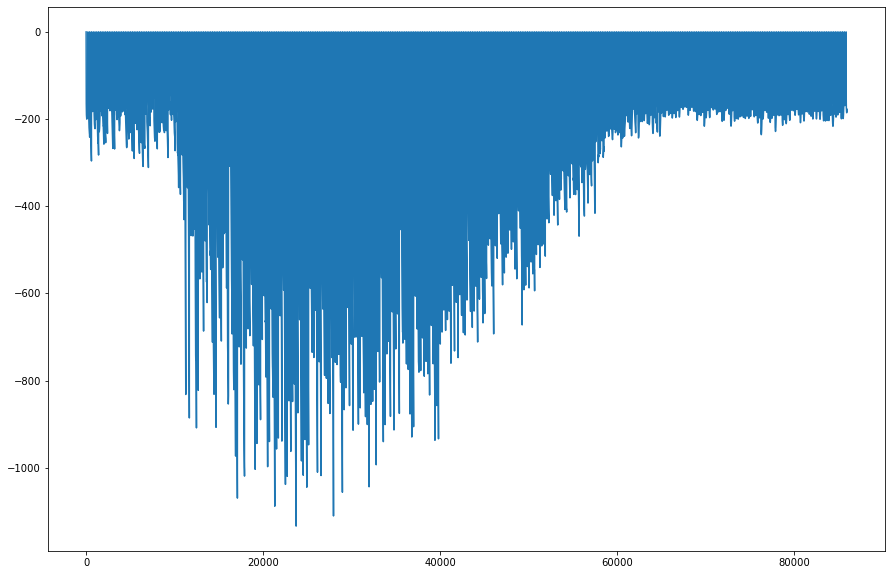

In [9]:
plt.plot(np.arange(len(Agent.log['avg_reward'])), Agent.log['avg_reward'])

In [10]:
Agent.test_episode(plot=True, env = env, 
                   load_model = 'models/Diffusion_38832_996742.pth')

-88.6181788382407

(array([-40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,   5.]),
 <a list of 10 Text yticklabel objects>)

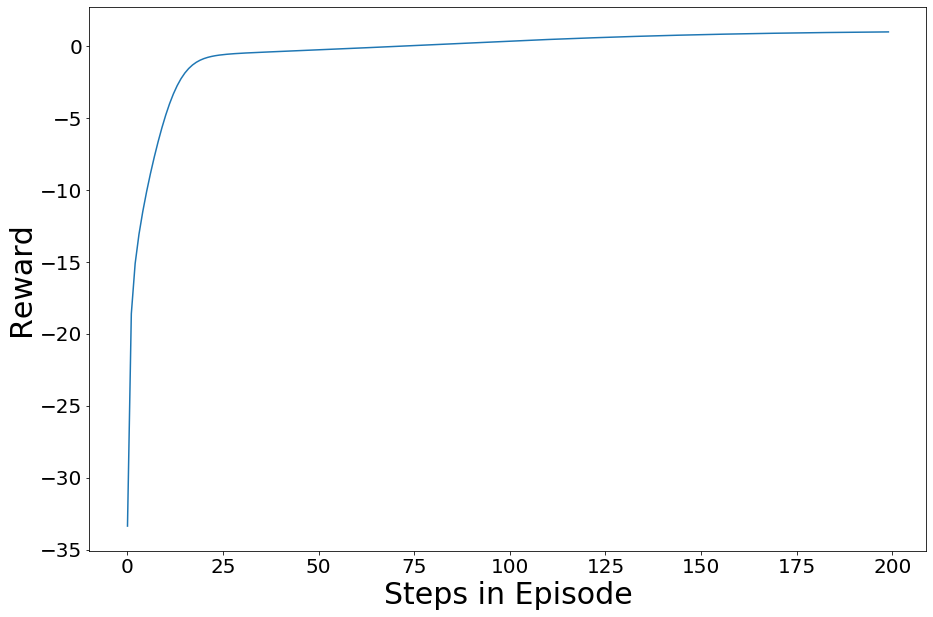

In [11]:
plt.plot(np.arange(len(env.info['reward'][-200:])), env.info['reward'][-200:])
plt.xlabel('Steps in Episode', size = 30)
plt.ylabel('Reward', size = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('images/OG_50_epsiodes_3894374.png', dpi = 500)

(-6, 3)

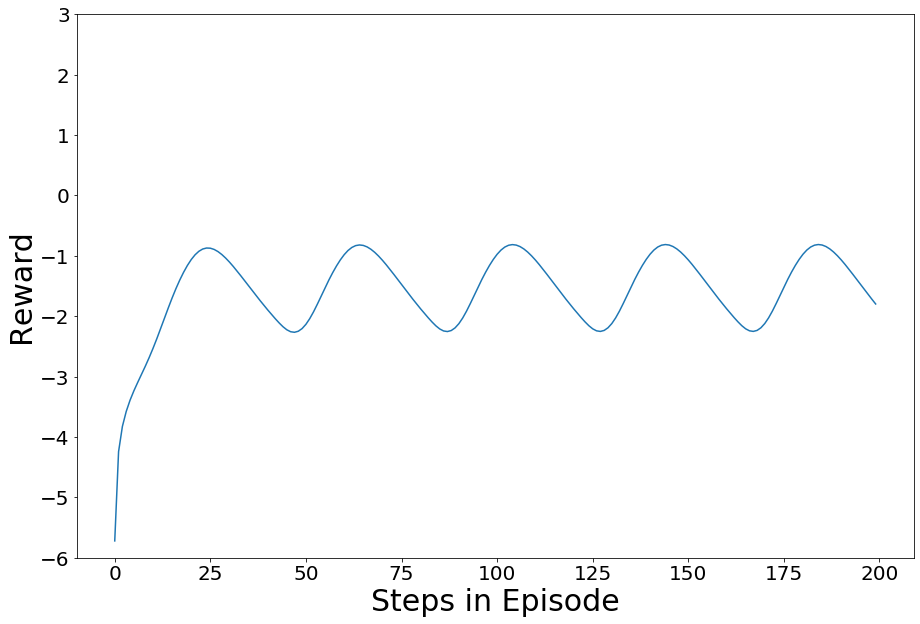

In [11]:
plt.plot(np.arange(len(env.info['energy'][-200:])), env.info['energy'][-200:])
plt.xlabel('Steps in Episode', size = 30)
plt.ylabel('Reward', size = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-6,3)
#plt.savefig('images/OG_50_epsiodes_3894374.png', dpi = 500)